In [51]:
import git
import time
import pandas as pd
from datetime import datetime, timedelta, date
import io
import numpy as np

Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['FIPS','UID','iso2','iso3','code3','Admin2',  'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])

US_Cases_df=US_Cases_df.melt(id_vars=['Province_State'], 
        var_name="Date", 
        value_name="Value")

US_Cases_df['Date']= pd.to_datetime(US_Cases_df['Date'])
US_Cases_df = US_Cases_df[US_Cases_df['Date'] > '2020-09-01']
US_State_Cases_df = US_Cases_df.groupby(['Province_State', 'Date'])['Value'].sum()
US_State_Cases_df = US_State_Cases_df.to_frame(name = 'Cumulative_Cases').reset_index()
US_State_Cases_df['week'] = US_State_Cases_df['Date'].dt.week +14
print(US_State_Cases_df['week'].unique())
US_State_Cases_df.loc[(US_State_Cases_df.week >= 50), 'week'] = US_State_Cases_df.loc[(US_State_Cases_df.week >= 50), 'week'] - 53
US_State_Cases_df = US_State_Cases_df.rename(columns={'Date': 'date', 'Province_State': 'State'})

weekly_covid_cases_df = US_State_Cases_df.groupby(['State', 'week'])['Cumulative_Cases'].mean()
weekly_covid_cases_df = weekly_covid_cases_df.to_frame(name = 'Mean_Cumulative_Cases').reset_index()

statesArray = weekly_covid_cases_df['State'].to_numpy()
cdArray = weekly_covid_cases_df['Mean_Cumulative_Cases'].to_numpy()
i = 0
j = 0
case_state = ''
for index, row in weekly_covid_cases_df.iterrows():
    state = row['State']
    if  (i > 0) & (statesArray[i-1] == state) :
        previous_cum_cases = cdArray[i-1]
        weekly_cases = row['Mean_Cumulative_Cases'] - previous_cum_cases
        weekly_covid_cases_df.at[index,'weekly_cases'] =  weekly_cases
        if previous_cum_cases  == 0:
            previous_cum_cases = 1        
        weekly_covid_cases_df.at[index, 'weekly_cases_per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
    else:
        caseState = state        
        weekly_covid_cases_df.at[index,'weekly_cases'] = 0
    i = i + 1
weekly_covid_cases_df.drop(weekly_covid_cases_df[weekly_covid_cases_df['week'] <=0 ].index, inplace = True)


Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Deaths_df = US_Deaths_df.drop(columns=['FIPS','Population','UID','iso2','iso3','code3','Admin2',  'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df = US_Deaths_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])
US_Deaths_df = US_Deaths_df.melt(id_vars=['Province_State'], 
        var_name="Date", 
        value_name="Value")
US_Deaths_df['Date']= pd.to_datetime(US_Deaths_df['Date'])
US_Deaths_df = US_Deaths_df[US_Deaths_df['Date'] > '2020-09-01']
US_State_Deaths_df = US_Deaths_df.groupby(['Province_State', 'Date'])['Value'].sum()
US_State_Deaths_df = US_State_Deaths_df.to_frame(name = 'Cumulative_Deaths').reset_index()

US_State_Deaths_df['week'] = US_State_Deaths_df['Date'].dt.week + 14
US_State_Deaths_df.loc[(US_State_Deaths_df.week >= 50), 'week'] = US_State_Deaths_df.loc[(US_State_Deaths_df.week >= 50), 'week'] - 53
US_State_Deaths_df = US_State_Deaths_df.rename(columns={'Date': 'date', 'Province_State': 'State'})
weekly_covid_deaths_df = US_State_Deaths_df.groupby(['State', 'week'])['Cumulative_Deaths'].mean()
weekly_covid_deaths_df = weekly_covid_deaths_df.to_frame(name = 'Mean_Cumulative_Deaths').reset_index()

statesArray = weekly_covid_deaths_df['State'].to_numpy()
cdArray = weekly_covid_deaths_df['Mean_Cumulative_Deaths'].to_numpy()
i = 0
j = 0
case_state = ''
for index, row in weekly_covid_deaths_df.iterrows():
    state = row['State']
    if  (i > 0) & (statesArray[i-1] == state) :
        previous_cum_deaths = cdArray[i-1]
        weekly_deaths = row['Mean_Cumulative_Deaths'] - previous_cum_deaths
        weekly_covid_deaths_df.at[index,'weekly_deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
            previous_cum_deaths = 1        
        weekly_covid_deaths_df.at[index, 'weekly_deaths_per'] = (weekly_deaths * 100.0) / (previous_cum_deaths * 1.0)
    else:
        caseState = state        
        weekly_covid_deaths_df.at[index,'weekly_deaths'] = 0
    i = i + 1
weekly_covid_deaths_df.drop(weekly_covid_deaths_df[weekly_covid_deaths_df['week'] <=0 ].index, inplace = True)
weekly_covid_deaths_df.to_csv("weekly_covid_deaths.csv")



em_url ='data/excess_state_deaths.csv'

excess_mortality_deaths = pd.read_csv(em_url, error_bad_lines=True)
excess_mortality_deaths = excess_mortality_deaths.rename(columns={'Week Ending Date': 'date', 'Excess Deaths': 'weekly_excess_deaths'})
excess_mortality_deaths['date']= pd.to_datetime(excess_mortality_deaths['date'])
excess_mortality_deaths['week'] = excess_mortality_deaths['date'].dt.week + 14
excess_mortality_deaths.loc[(excess_mortality_deaths.week >= 54), 'week'] = excess_mortality_deaths.loc[(excess_mortality_deaths.week >= 54), 'week'] - 53
excess_mortality_deaths = excess_mortality_deaths[(excess_mortality_deaths['date'] > '2020-10-01')]
states = excess_mortality_deaths[excess_mortality_deaths['weekly_excess_deaths'].isna()]['State'].unique()
states = np.append(states,['District of Columbia','Hawaii','New York City','United States', 'Alaska','Puerto Rico'])
weekly_excess_mortality_deaths = excess_mortality_deaths[~excess_mortality_deaths['State'].isin(states)]
weekly_covid_deaths_df = weekly_covid_deaths_df[~weekly_covid_deaths_df['State'].isin(states)]
weekly_covid_cases_df = weekly_covid_cases_df[~weekly_covid_cases_df['State'].isin(states)]

weekly_covid_cases_df

[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 15 16 17 18 19 20
 21 22 23 24 25 26]


,State,week,Mean_Cumulative_Cases,weekly_cases,weekly_cases_per
4,Alabama,1,155819.000000,7243.428571,4.875249
5,Alabama,2,162534.000000,6715.000000,4.309487
6,Alabama,3,169810.142857,7276.142857,4.476690
7,Alabama,4,179635.857143,9825.714286,5.786294
8,Alabama,5,190299.428571,10663.571429,5.936215
...,...,...,...,...,...
1735,Wyoming,22,54161.142857,642.714286,1.200921
1736,Wyoming,23,54655.857143,494.714286,0.913412
1737,Wyoming,24,55070.000000,414.142857,0.757728
1738,Wyoming,25,55478.571429,408.571429,0.741913


In [52]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [53]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
#county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
#county_covariates.FIPS = county_covariates.FIPS.astype('int64')
#county_covariates=county_covariates.set_index('FIPS')
#age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
#county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
#FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
#covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
#covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
#covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
#covariates = covariates.drop(['County','State'], axis=1)
#dropping full NaN counties
#covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
#US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
#US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
#list(covariates.columns) 
#covariates = covariates.dropna(axis='columns')
#list(covariates.columns) 

state_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/states_only.csv')
state_covariates = state_covariates.drop([0,2, 9, 52])
state_age_race=pd.read_csv('https://docs.google.com/spreadsheets/d/1Jd18jMFRCqYRyTRTOT-mU2m9ine8tabnIhDJx91KLu8/export?format=csv')
covariates = state_age_race.merge(state_covariates, how='inner', left_on=["STNAME"], right_on=['Area_Name'])

covariates = covariates.drop([ 'County', 'State', 'Area_Name'], axis=1)
covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
covariates=covariates.dropna(axis='columns', thresh=1)
col_name="FIPS"
first_col = covariates.pop(col_name)
covariates.insert(0, col_name, first_col)
covariates = covariates.rename(columns={'19-Oct': '10-19'})

covariates=covariates[['FIPS','STNAME',
 'TOT_POP',
'40-49 y/o % of total pop',
'50-59',
'50-59 y/o % of total pop',
'60-69',
'60-69 y/o % of total pop',
'70-79',
'70-79 y/o % of total pop',
'80+',
'80+ y/o % of total pop',
'White-alone pop',
'% White-alone',
'Black-alone pop',
'% Black-alone',
"Bachelor's degree or higher 2014-18",
'Percent of adults with less than a high school diploma 2014-18',
'Percent of adults with a high school diploma only 2014-18',
'Jan Precipitation / inch',
'Jun Precipitation / inch',
'Jan Temp AVG / F',
'Jun Temp AVG / F',
'Active Physicians per 100000 Population 2018 (AAMC)',
'Total Hospitals (2019)']]
covariates = covariates[~covariates['STNAME'].isin(states)]
covariates

,FIPS,STNAME,TOT_POP,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,...,% Black-alone,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Jan Precipitation / inch,Jun Precipitation / inch,Jan Temp AVG / F,Jun Temp AVG / F,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019)
0,1000,Alabama,4887871,12.301348,651303,13.324881,589167,12.053653,367780,7.524339,...,26.817443,822595,14.2,30.9,6.10,4.46,46.06,77.80,217.1,101.0
1,4000,Arizona,7171646,11.903948,860710,12.001568,813921,11.349152,575927,8.030611,...,5.079448,1338071,13.2,24.0,1.45,0.05,44.23,76.53,242.0,83.0
2,5000,Arkansas,3013825,11.978698,382658,12.696756,348865,11.575490,228684,7.587833,...,15.670684,451621,13.8,34.1,4.51,6.11,40.69,75.56,207.6,88.0
3,6000,California,39557045,12.813834,5022701,12.697362,4115518,10.404008,2409030,6.090015,...,6.461554,8718737,17.1,20.6,6.68,0.10,46.68,69.08,279.6,359.0
4,8000,Colorado,5695564,12.862677,709866,12.463489,631401,11.085838,346828,6.089441,...,4.559882,1504892,8.6,21.4,1.48,1.69,25.49,59.59,285.7,89.0
5,9000,Connecticut,3572665,12.327940,529442,14.819246,432658,12.110231,260636,7.295282,...,12.016184,965227,9.5,27.1,5.95,3.47,27.55,66.72,352.1,32.0
6,10000,Delaware,967171,11.481941,132852,13.736144,126360,13.064908,81485,8.425087,...,22.960779,207232,10.2,31.6,3.41,5.57,34.77,73.67,284.6,7.0
7,12000,Florida,21299325,12.216523,2865097,13.451586,2655901,12.469414,1959208,9.198451,...,16.902512,4283457,12.0,28.8,4.01,7.71,57.52,82.18,265.2,217.0
8,13000,Georgia,10519475,13.173595,1375366,13.074474,1104311,10.497777,654183,6.218780,...,32.426951,2080116,13.3,27.9,5.14,5.96,47.60,77.76,228.7,145.0
10,16000,Idaho,1754208,11.761319,206861,11.792273,200787,11.446020,123864,7.060964,...,0.899266,293269,9.4,27.7,2.15,0.96,26.64,58.56,192.6,45.0


In [54]:
def merge_dataset(weekly_total_deaths_df, weekly_deaths_df, weekly_cases_df): 
    weekly_deaths_prior_one_weeks_df = weekly_deaths_df.copy() 
    weekly_deaths_prior_one_weeks_df["week"] = weekly_deaths_prior_one_weeks_df["week"] + 1
    weekly_deaths_prior_one_weeks_df.rename(columns = {'weekly_deaths':'one_week_prior_weekly_deaths','weekly_deaths_per' : 'one_week_prior_weekly_deaths_per' }, inplace = True)
    
    weekly_deaths_prior_two_weeks_df = weekly_deaths_df.copy() 
    weekly_deaths_prior_two_weeks_df["week"] = weekly_deaths_prior_two_weeks_df["week"] + 2
    weekly_deaths_prior_two_weeks_df.rename(columns = {'weekly_deaths':'two_week_prior_weekly_deaths','weekly_deaths_per' : 'two_week_prior_weekly_deaths_per'}, inplace = True)
    
    weekly_deaths_prior_three_weeks_df = weekly_deaths_df.copy() 
    weekly_deaths_prior_three_weeks_df["week"] = weekly_deaths_prior_three_weeks_df["week"] + 3
    weekly_deaths_prior_three_weeks_df.rename(columns = {'weekly_deaths':'three_week_prior_weekly_deaths','weekly_deaths_per' : 'three_week_prior_weekly_deaths_per'}, inplace = True)
    
    weekly_deaths_merged_df = weekly_total_deaths_df.merge(weekly_deaths_prior_two_weeks_df[['two_week_prior_weekly_deaths','two_week_prior_weekly_deaths_per',  'State', 'week']], how='left', left_on=['State',  'week'], right_on=['State',  'week'])
    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_deaths_prior_three_weeks_df[['three_week_prior_weekly_deaths', 'three_week_prior_weekly_deaths_per','State', 'week']], how='left', left_on=['State',  'week'], right_on=['State', 'week'])
    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_deaths_prior_one_weeks_df[['one_week_prior_weekly_deaths', 'one_week_prior_weekly_deaths_per', 'State', 'week']], how='left', left_on=['State',  'week'], right_on=['State', 'week'])

    
    weekly_cases_prior_two_weeks_df = weekly_cases_df.copy() 
    weekly_cases_prior_two_weeks_df["week"] = weekly_cases_df["week"] + 2
    weekly_cases_prior_two_weeks_df.rename(columns = {'weekly_cases':'two_week_prior_weekly_cases'}, inplace = True)
    weekly_cases_prior_three_weeks_df = weekly_cases_df.copy() 
    weekly_cases_prior_three_weeks_df["week"] = weekly_cases_df["week"] + 3
    weekly_cases_prior_three_weeks_df.rename(columns = {'weekly_cases':'three_week_prior_weekly_cases'}, inplace = True)

    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_cases_prior_two_weeks_df[['two_week_prior_weekly_cases', 'State', 'week']], how='left', left_on=['State',  'week'], right_on=['State',  'week'])
    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_cases_prior_three_weeks_df[['three_week_prior_weekly_cases', 'State', 'week']], how='left', left_on=['State',  'week'], right_on=['State',  'week'])
    return weekly_deaths_merged_df

In [55]:
weekly_deaths_merged_df = merge_dataset(weekly_excess_mortality_deaths,weekly_covid_deaths_df,weekly_covid_cases_df) 
covariates_merged = covariates.merge(weekly_deaths_merged_df[['one_week_prior_weekly_deaths',
                                                                                'two_week_prior_weekly_deaths', 
                                                              'three_week_prior_weekly_deaths',
                                                              'one_week_prior_weekly_deaths_per',
                                                              'two_week_prior_weekly_deaths_per',
                                                              'three_week_prior_weekly_deaths_per',
                                                              'two_week_prior_weekly_cases',
                                                              'three_week_prior_weekly_cases',
                                            'State',  'week']], how='inner', left_on=["STNAME"], right_on=['State'])
State_Pop = dict(zip(covariates_merged.STNAME, covariates_merged.TOT_POP))
State_FIPS = dict(zip(covariates_merged.STNAME, covariates_merged.FIPS))
covariates_merged = covariates_merged.drop([ 'STNAME', 'State'], axis=1)


In [56]:
from sklearn.model_selection import StratifiedKFold
def run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,weekly_deaths_merged_df,predict_column_index,best_fit_scores,index):
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['week'].isin(train_week))] 
    covariates_train_week =covariates_train_week.drop(['week'], axis=1)
    weekly_deaths_train_week = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(train_week))].iloc[:, predict_column_index]  
    if len(weekly_deaths_merged_df) > 0:
       
        X_train = covariates_train_week
        Y_train = weekly_deaths_train_week
        #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
        xgbReg = xgb.XGBRegressor()

        parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
              'max_depth': [1,2,3,4],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'colsample_bytree' : [0.8],
              'n_estimators': [ 100,200]}
        tscv = StratifiedKFold(n_splits=2, shuffle=False, random_state = None)
        xgb_grid = GridSearchCV(xgbReg,
                        parameters,
                        cv = tscv,
                        n_jobs = 4,
                        scoring = 'r2',
                        verbose=True)

        xgb_grid.fit(X_train,Y_train)


        print(xgb_grid.best_score_)
        print(xgb_grid.best_params_)
        results = xgb_grid.cv_results_
        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        #print ("predicting next week series :" , predict_week.array)

        X_predict_week = covariates_merged.loc[(covariates_merged['week'].isin(predict_week))]
        X_predict_week = X_predict_week.drop(['week'], axis=1)
        predict_week_df = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(predict_week))]
        Y_actual_predict_week = predict_week_df.iloc[:,predict_column_index]
        #best_reg.fit(X_tune_week, Y_actual_tune_week)
        Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
        print(X_predict_week.shape)
        print(Y_predict_week.shape)

        predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
        print(predict_score)
        best_fit_scores.loc[index] = [str(predict_start_week_day), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]

        return Y_predict_week, Y_actual_predict_week
    return None
       

In [57]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

def run_model_internal(covariates_merged, weekly_deaths_merged_df, best_fit_scores):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")


    min_week = weekly_deaths_merged_df['week'].min()
    max_week = weekly_deaths_merged_df['week'].max()


    num_weeks=int((max_week-min_week))
    print("min_week: " , min_week, " max week: ", max_week, " number of weeks : " , num_weeks)
    prediction_weeks = 2 # three weks train , tune and forecast

    index = 0 
    train_start_week_day = 1
    train_end_week_day = train_start_week_day + prediction_weeks

    predict_start_week_day = train_end_week_day 
    predict_end_week_day = predict_start_week_day + 1

    print("train:", train_start_week_day ,":", train_end_week_day, 
            " predict:" , predict_start_week_day, ":",  predict_end_week_day)

    predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Population','Forecast_Day','Week','Predicted_Weekly_Excess_Deaths','Actual_Weekly_Excess_Deaths'])
    for week_num in range(num_weeks):
        if (predict_end_week_day-1) > max_week:
            break
        predicted_df = pd.DataFrame(columns=['State','FIPS','Population', 'Forecast_Day','Week','Predicted_Weekly_Excess_Deaths', 'Actual_Weekly_Excess_Deaths'])
        predicted_deaths, actual_deaths = run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
                  covariates_merged,weekly_deaths_merged_df,2,best_fit_scores,index) 

        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        predict_week_df = covariates_merged.loc[(covariates_merged['week'].isin(predict_week))]
        predicted_df["FIPS"] = predict_week_df['FIPS']
        predicted_df["Week"] = predict_week_df["week"]
        forecast_day = (covid_start_date + timedelta(days=(predict_start_week_day*7 + 6))).strftime("%Y-%m-%d")
        predicted_df["Forecast_Day"] = forecast_day 
        predicted_df["Predicted_Weekly_Excess_Deaths"] = predicted_deaths
        predicted_df["Actual_Weekly_Excess_Deaths"] = actual_deaths
        #predicted_df.to_csv("data/predictions/predicted_us_deaths_" +  forecast_day + ".csv")                     
        predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])
        train_start_week_day = train_start_week_day + 1
        train_end_week_day = train_end_week_day + 1
        predict_start_week_day = predict_start_week_day + 1
        predict_end_week_day = predict_start_week_day + 1
        index = index + 1
    return predicted_df_all_days
    
best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = run_model_internal(covariates_merged, weekly_deaths_merged_df, best_fit_scores)
best_fit_scores.to_csv("best_fit_scores_v3.csv", index=False)
best_fit_scores

min_week:  1  max week:  23  number of weeks :  22
train: 1 : 3  predict: 3 : 4
train: 1 : 3  predict: 3 : 4
Fitting 2 folds for each of 48 candidates, totalling 96 fits


/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    2.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7467143571139135
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.8423354313609872
train: 2 : 4  predict: 4 : 5
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7486881619829663
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.7835606158942249
train: 3 : 5  predict: 5 : 6
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.6538795156693641
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.7808234539765914
train: 4 : 6  predict: 6 : 7
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.6736244422877826
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.7070215013137386
train: 5 : 7  predict: 7 : 8
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8233489922117436
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.8922731670201524
train: 6 : 8  predict: 8 : 9
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9075266121223177
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.909444380654286
train: 7 : 9  predict: 9 : 10
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9089353115378296
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.8873117942055212
train: 8 : 10  predict: 10 : 11
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7964565745849999
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.9018313050313314
train: 9 : 11  predict: 11 : 12
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9030992983865973
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.8681134364763665
train: 10 : 12  predict: 12 : 13
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9157801468863743
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.8978421624460432
train: 11 : 13  predict: 13 : 14
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9490078760227261
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.9156725261455302
train: 12 : 14  predict: 14 : 15
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9236188879096043
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.9566307020861149
train: 13 : 15  predict: 15 : 16
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9560620708585257
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.9714476902227032
train: 14 : 16  predict: 16 : 17
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.930295480995273
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.9753295659484383
train: 15 : 17  predict: 17 : 18
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7978339568008687
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.8271912223850206
train: 16 : 18  predict: 18 : 19
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8941991910128277
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.6342536316458448
train: 17 : 19  predict: 19 : 20
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8798226813938614
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
0.7388021459572104
train: 18 : 20  predict: 20 : 21
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8323501044716171
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
-0.21031333269420194
train: 19 : 21  predict: 21 : 22
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.7s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.6291644271389193
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
-0.1668958988369702
train: 20 : 22  predict: 22 : 23
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.7s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.5713374483684894
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
-3.387103189940137
train: 21 : 23  predict: 23 : 24
Fitting 2 folds for each of 48 candidates, totalling 96 fits
0.2554405987395586
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(48, 32)
(48,)
-28.59027330430954


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished


,Week Duration,Best_Parameters,Best_Score,Predict_R2_Score
0,3,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.746714,0.842335
1,4,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.748688,0.783561
2,5,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.653880,0.780823
3,6,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.673624,0.707022
4,7,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.823349,0.892273
5,8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.907527,0.909444
6,9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.908935,0.887312
7,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.796457,0.901831
8,11,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.903099,0.868113
9,12,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.915780,0.897842


   Week Duration                                    Best_Parameters  \
0              3  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
1              4  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
2              5  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
3              6  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
4              7  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
5              8  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
6              9  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
7             10  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
8             11  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
9             12  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
10            13  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
11            14  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
12            15  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
13    

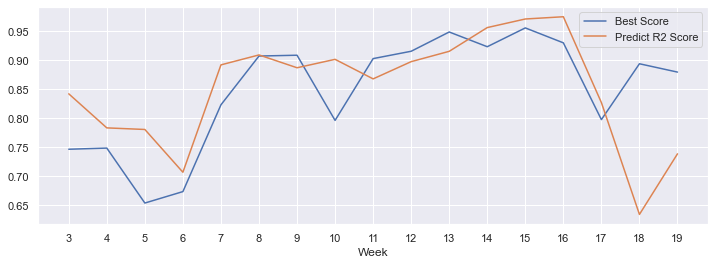

<Figure size 432x288 with 0 Axes>

In [58]:
import seaborn as sns
def drawGraphs(best_fit_scores, cat):
    sns.set()

    x = best_fit_scores['Week Duration']
    y = best_fit_scores['Best_Score']
    z = best_fit_scores['Predict_R2_Score']

    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)

    plt.xlabel('Week')

    ax.plot(x, y, label ='Best Score')

    ax.plot(x, z, label ='Predict R2 Score')
    plt.legend()
    plt.show()
    plt.savefig(cat + '_r2_score.png')

print(best_fit_scores)
best_fit_scores = best_fit_scores[(best_fit_scores['Week Duration'].astype(int)) < 20]
drawGraphs(best_fit_scores, 'Pred_Actual')

In [91]:
dates = ['2020-09-27','2020-10-04','2020-10-11','2020-10-18','2020-10-25','2020-11-01','2020-11-08','2020-11-15','2020-11-22','2020-11-29',
         '2020-12-06','2020-12-13','2020-12-20','2020-12-27','2020-12-28','2021-01-03','2021-01-04','2021-01-10','2021-01-11', '2021-01-17','2021-01-18', '2021-01-24','2021-01-25', '2021-01-31','2021-02-01', '2021-02-07','2021-02-08', '2021-02-14','2021-02-15', '2021-02-21','2021-02-22', '2021-02-28','2021-03-01']
US_Deaths_Forecasts_df = pd.read_csv("data/MIT_CritData-GBCF_deaths_forecasts.csv", error_bad_lines=True)
US_Deaths_Forecasts_df = US_Deaths_Forecasts_df[~US_Deaths_Forecasts_df['location'].isin(states)]
US_Deaths_Forecasts_df['target_end_date']= pd.to_datetime(US_Deaths_Forecasts_df['target_end_date'])
#US_Deaths_Forecasts_df['week'] = US_Deaths_Forecasts_df['target_end_date'].dt.week 
US_Deaths_Forecasts_df['week'] = US_Deaths_Forecasts_df['target_end_date'].dt.week + 14
US_Deaths_Forecasts_df.loc[(US_Deaths_Forecasts_df.week >= 54), 'week'] = US_Deaths_Forecasts_df.loc[(US_Deaths_Forecasts_df.week >= 54), 'week'] - 53

US_Deaths_Forecasts_df= US_Deaths_Forecasts_df.sort_values(by=['location','week'])

statesArray = US_Deaths_Forecasts_df['location'].to_numpy()
cdArray = US_Deaths_Forecasts_df['value'].to_numpy()
i = 0
j = 0
case_state = ''
US_Deaths_Forecasts_df['weekly_deaths'] = 0
for index, row in US_Deaths_Forecasts_df.iterrows():
    state = row['location']
    if  (i > 0) & (statesArray[i-1] == state) :
        previous_cum_deaths = cdArray[i-1]
        weekly_deaths = row['value'] - previous_cum_deaths
        US_Deaths_Forecasts_df.at[index,'weekly_deaths'] =  weekly_deaths
    else:
        caseState = state        
        US_Deaths_Forecasts_df.at[index,'weekly_deaths'] = 0
    i = i + 1

print (US_Deaths_Forecasts_df[US_Deaths_Forecasts_df['location'] == 'Alabama'])

dates = ['2020-09-26','2020-10-03','2020-10-10','2020-10-17','2020-10-24','2020-10-31','2020-11-07','2020-11-14','2020-11-21','2020-11-28',
         '2020-12-05','2020-12-12','2020-12-19','2020-12-26','2021-01-02','2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30', '2021-02-06','2021-02-13', '2021-02-20', '2021-02-27','2021-03-06']

Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Actual_Deaths_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Actual_Deaths_df = US_Actual_Deaths_df.drop(columns=['FIPS','Population','UID','iso2','iso3','code3','Admin2',  'Country_Region','Lat','Long_','Combined_Key'])
US_Actual_Deaths_df = US_Actual_Deaths_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])
US_Actual_Deaths_df = US_Actual_Deaths_df.melt(id_vars=['Province_State'], 
        var_name="Date", 
        value_name="Value")
US_Actual_Deaths_df['Date']= pd.to_datetime(US_Actual_Deaths_df['Date'])
US_Actual_Deaths_df = US_Actual_Deaths_df[US_Actual_Deaths_df['Date'].isin(dates)]

US_Actual_Deaths_df['week'] = US_Actual_Deaths_df['Date'].dt.week + 14
US_Actual_Deaths_df.loc[(US_Actual_Deaths_df.week >= 54), 'week'] = US_Actual_Deaths_df.loc[(US_Actual_Deaths_df.week >= 54), 'week'] - 53

US_Actual_Deaths_df= US_Actual_Deaths_df.sort_values(by=['Province_State','week'])
US_Actual_Deaths_df = US_Actual_Deaths_df.groupby(['Province_State', 'week'])['Value'].sum()
US_Actual_Deaths_df = US_Actual_Deaths_df.to_frame(name = 'Cumulative_Deaths').reset_index()

statesArray = US_Actual_Deaths_df['Province_State'].to_numpy()
cdArray = US_Actual_Deaths_df['Cumulative_Deaths'].to_numpy()
i = 0
j = 0
case_state = ''
US_Actual_Deaths_df['weekly_deaths'] = 0
for index, row in US_Actual_Deaths_df.iterrows():
    state = row['Province_State']
    if  (i > 0) & (statesArray[i-1] == state) :
        previous_cum_deaths = cdArray[i-1]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Actual_Deaths_df.at[index,'weekly_deaths'] =  weekly_deaths
    else:
        caseState = state        
        US_Actual_Deaths_df.at[index,'weekly_deaths'] = 0
    i = i + 1
print (US_Actual_Deaths_df[US_Actual_Deaths_df['Province_State'] == 'Alabama'])

     forecast_date                target target_end_date location   type  \
1       2020-09-27  1 wk ahead cum death      2020-10-03  Alabama  point   
53      2020-10-04  1 wk ahead cum death      2020-10-10  Alabama  point   
105     2020-10-11  1 wk ahead cum death      2020-10-17  Alabama  point   
157     2020-10-18  1 wk ahead cum death      2020-10-24  Alabama  point   
209     2020-10-25  1 wk ahead cum death      2020-10-31  Alabama  point   
261     2020-11-01  1 wk ahead cum death      2020-11-07  Alabama  point   
313     2020-11-08  1 wk ahead cum death      2020-11-14  Alabama  point   
365     2020-11-15  1 wk ahead cum death      2020-11-21  Alabama  point   
417     2020-11-22  1 wk ahead cum death      2020-11-28  Alabama  point   
469     2020-11-29  1 wk ahead cum death      2020-12-05  Alabama  point   
521     2020-12-06  1 wk ahead cum death      2020-12-12  Alabama  point   
573     2020-12-13  1 wk ahead cum death      2020-12-19  Alabama  point   
625     2020

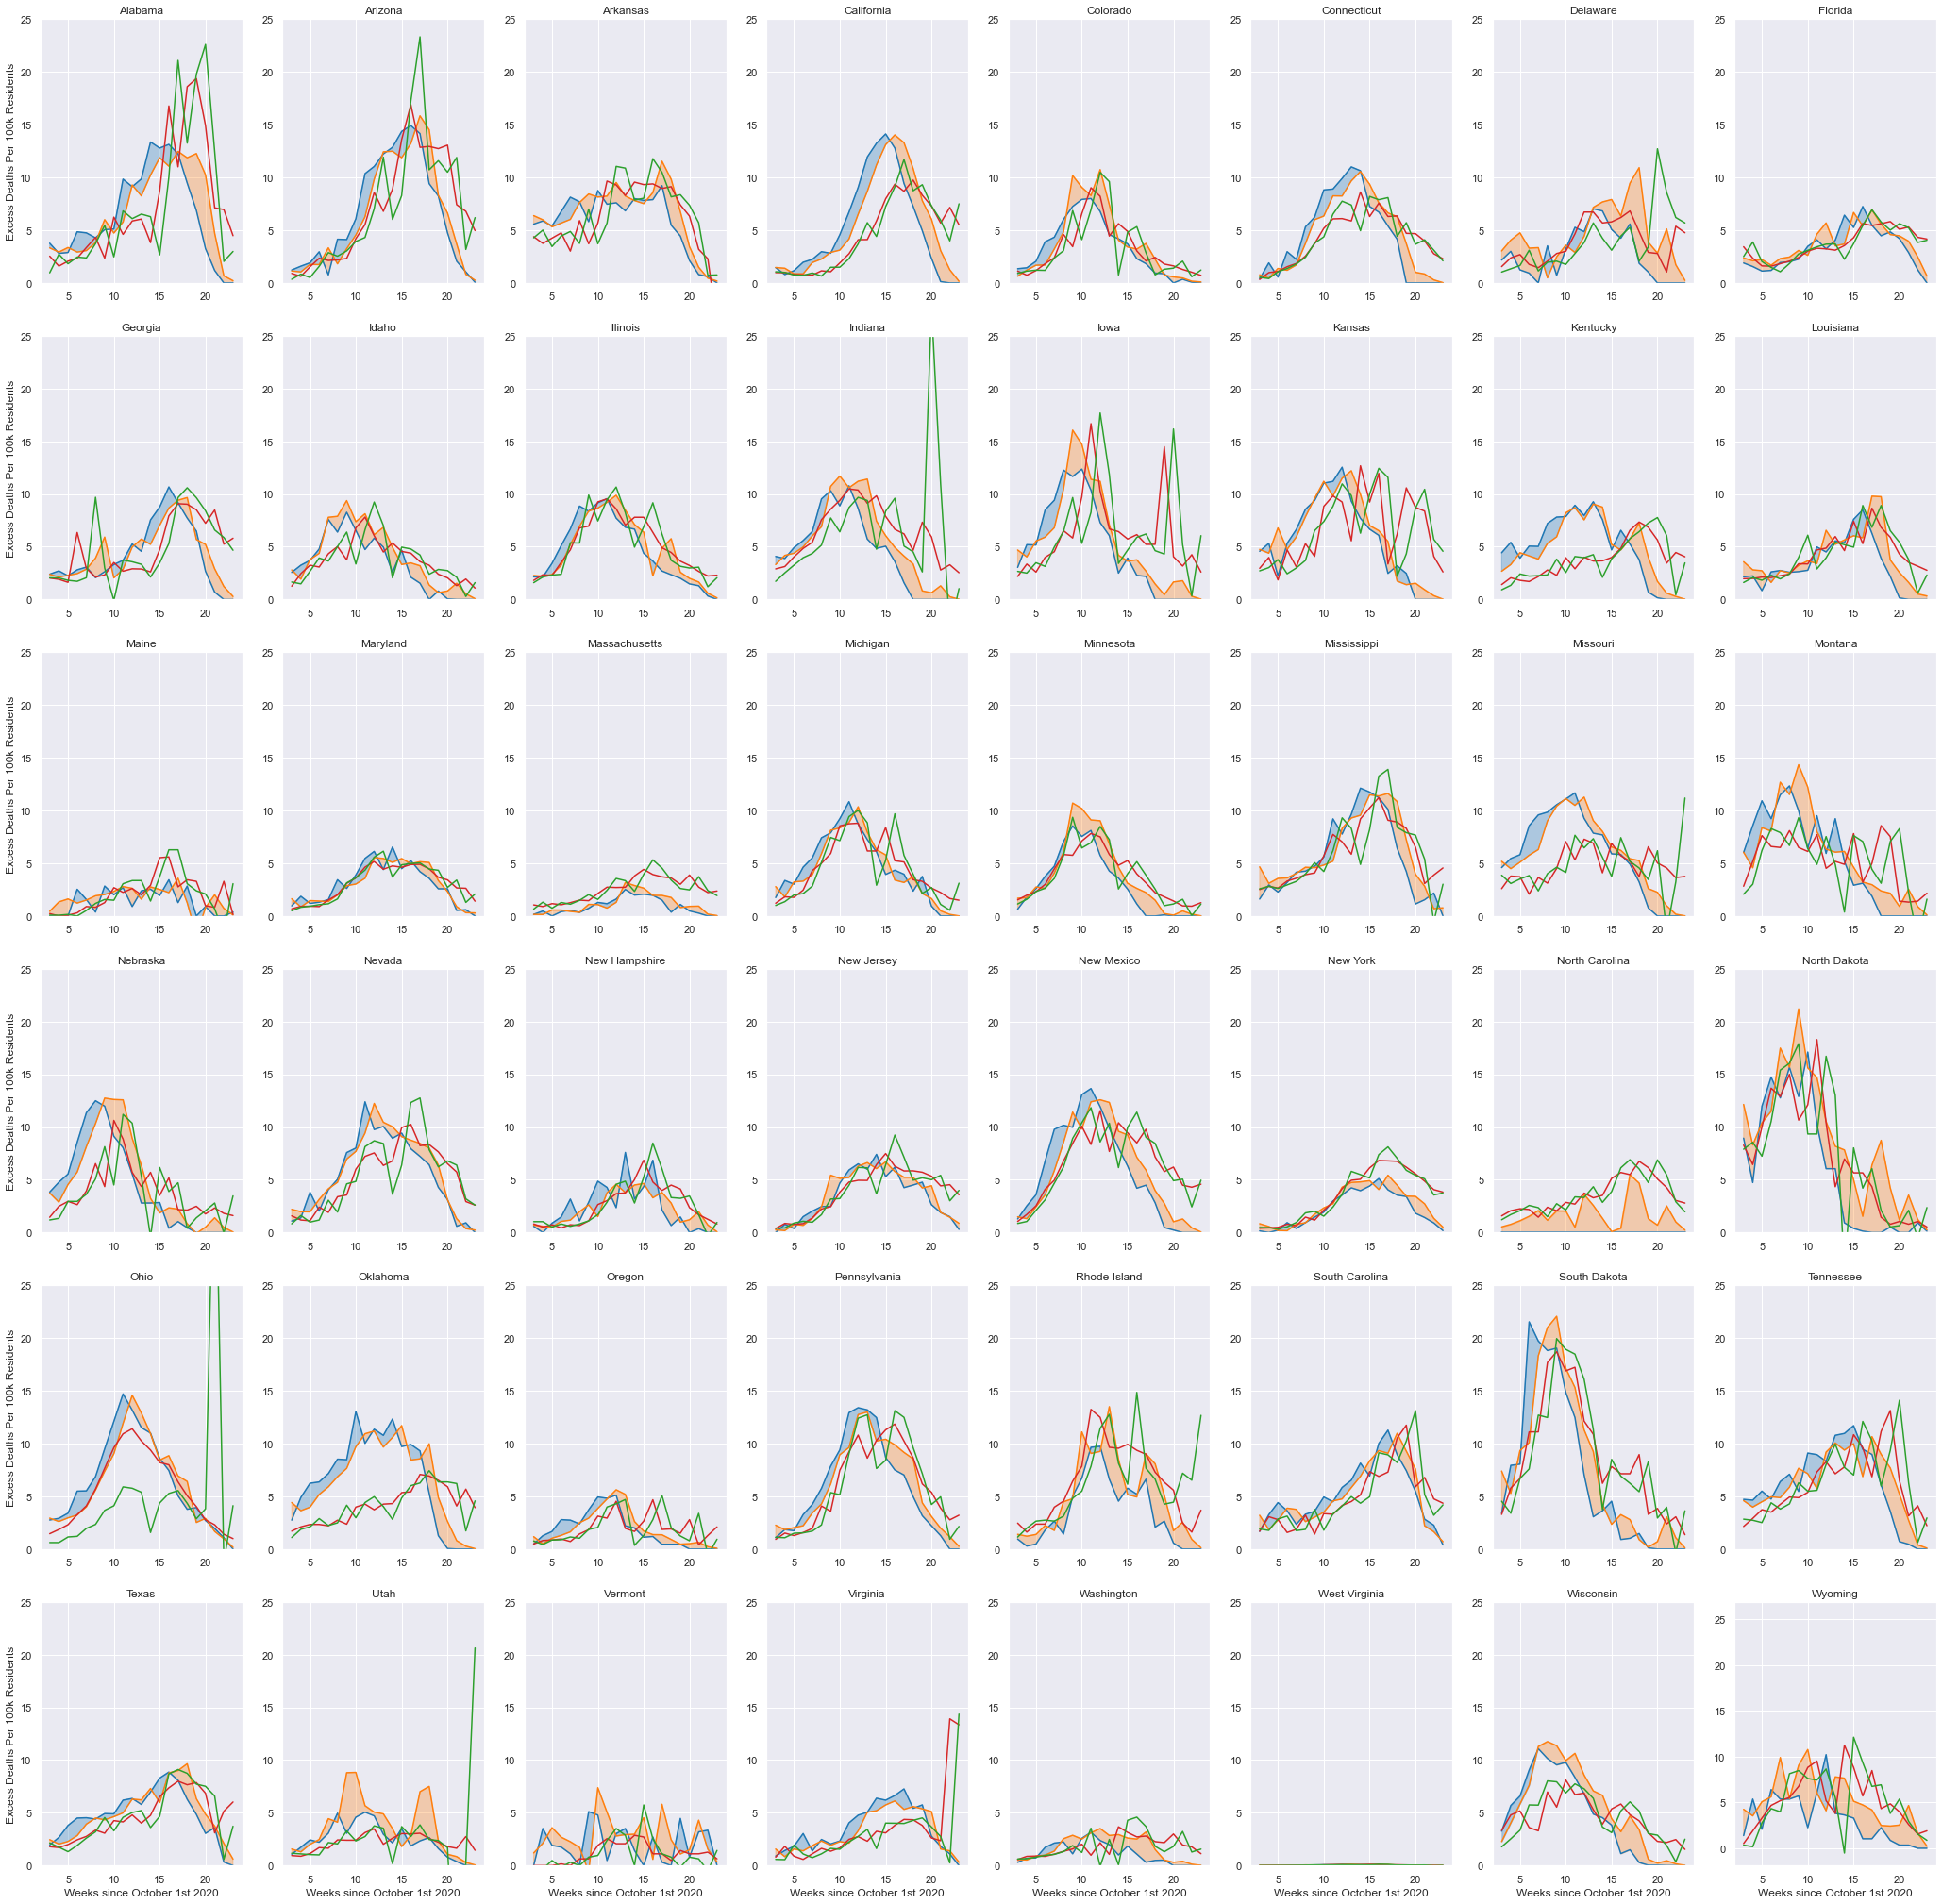

In [92]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt


fig, axes = plt.subplots(6,8, figsize=(36,36))
plt.xlim(1,25)
plt.axis('equal')

def drawGraphs():
    i = 0
    j = 0
    for state,pop in State_Pop.items():
         
        actual_excess_deaths = excess_mortality_deaths[(excess_mortality_deaths['State'] == state) & (excess_mortality_deaths['week'] > 2) & (excess_mortality_deaths['week']<=23)]
        actual_covid_deaths = US_Actual_Deaths_df[(US_Actual_Deaths_df['Province_State'] == state) & (US_Actual_Deaths_df['week'] > 2) &  (US_Actual_Deaths_df['week'] <=23)]
        predicted_covid_deaths = US_Deaths_Forecasts_df[(US_Deaths_Forecasts_df['location'] == state) & (US_Deaths_Forecasts_df['week'] > 2) &  (US_Deaths_Forecasts_df['week'] <=23)]        
        predicted_excess_deaths = predicted_df_all_days[predicted_df_all_days['FIPS'] == State_FIPS[state]]['Predicted_Weekly_Excess_Deaths']

        
        x = actual_excess_deaths['week']
        y = (actual_excess_deaths['weekly_excess_deaths'] * 100000) /pop
        z = (predicted_excess_deaths * 100000) /pop
        v = (actual_covid_deaths['weekly_deaths'] * 100000) /pop
        w = (predicted_covid_deaths['weekly_deaths'] * 100000) /pop
     
        axes[i,j].title.set_text(state)
        if j==0:
            axes[i,j].set_ylabel('Excess Deaths Per 100k Residents')
        if i==5:
            axes[i,j].set_xlabel('Weeks since October 1st 2020')
        axes[i,j].set_ylim(0,25)
        axes[i,j].plot(x, y,label ='Actual Weekly Excess deaths (state =' + state +' )',c='tab:blue')
        axes[i,j].plot(x, z,label ='Predicted Weekly Excess deaths (state =' + state +' )',c='tab:orange')
        axes[i,j].plot(x, v,label ='Actual Weekly Covid deaths (state =' + state +' )',c='tab:red')
        axes[i,j].plot(x, w,label ='Predicted Weekly Covid deaths (state =' + state +' )',c='tab:green')
       
        axes[i,j].fill_between(x, y, z, where=(y.to_numpy() > z.to_numpy()), color='tab:blue', alpha=0.3,
                 interpolate=True)
        axes[i,j].fill_between(x, y, z, where=(z.to_numpy() >= y.to_numpy()), color='tab:orange', alpha=0.3,
                 interpolate=True)
        if j <7:
            j = j + 1
        else:
            i=i+1
            j=0
        
    #axes[ax].legend()
   
    

drawGraphs()
plt.show()

           